Computing mask...


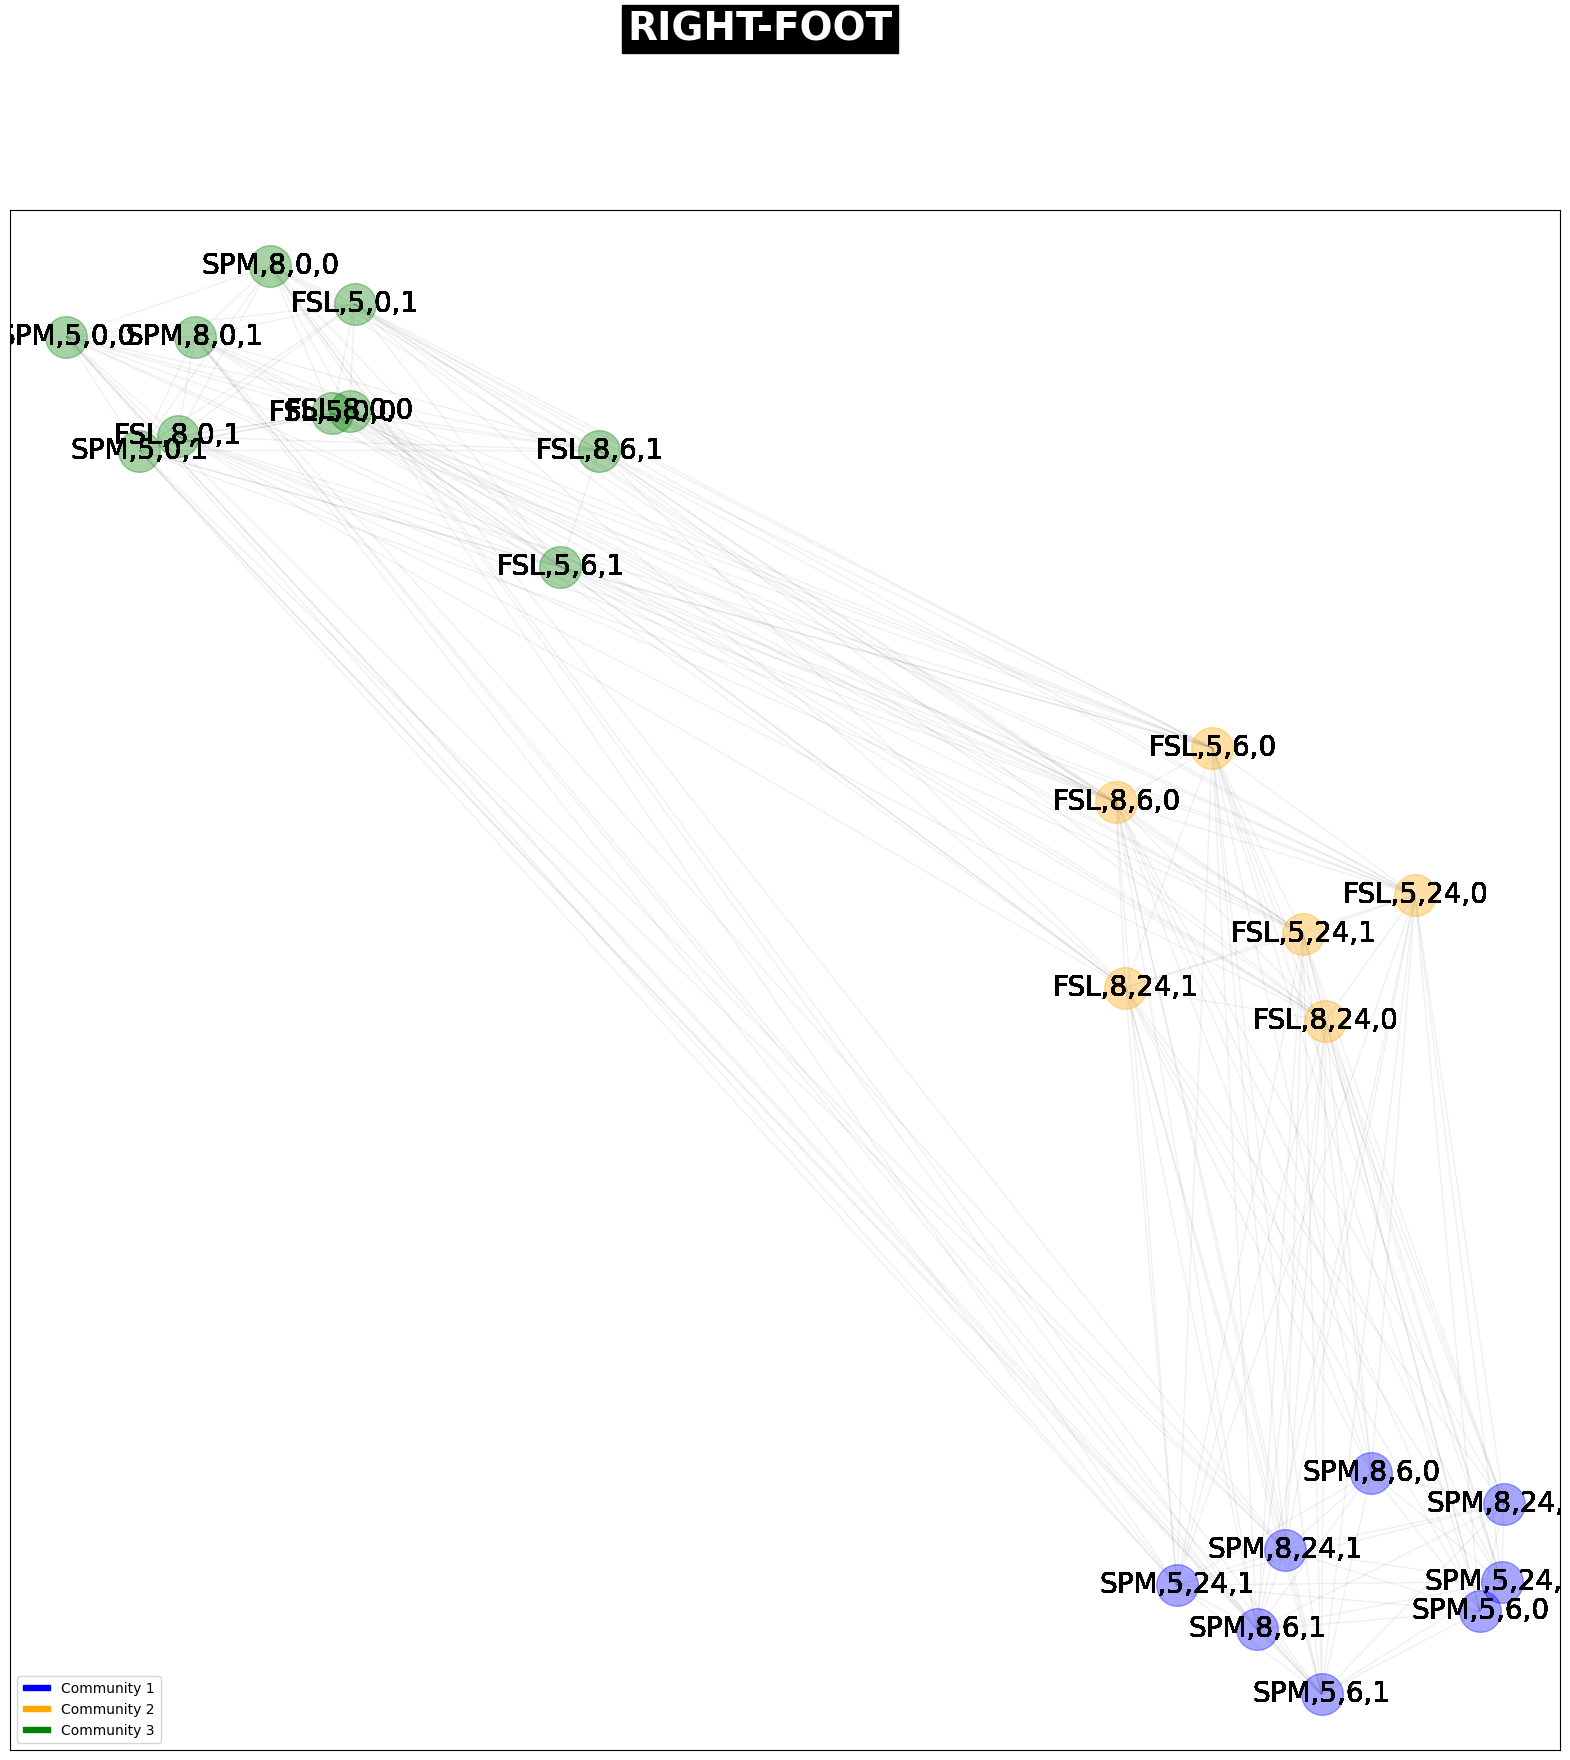

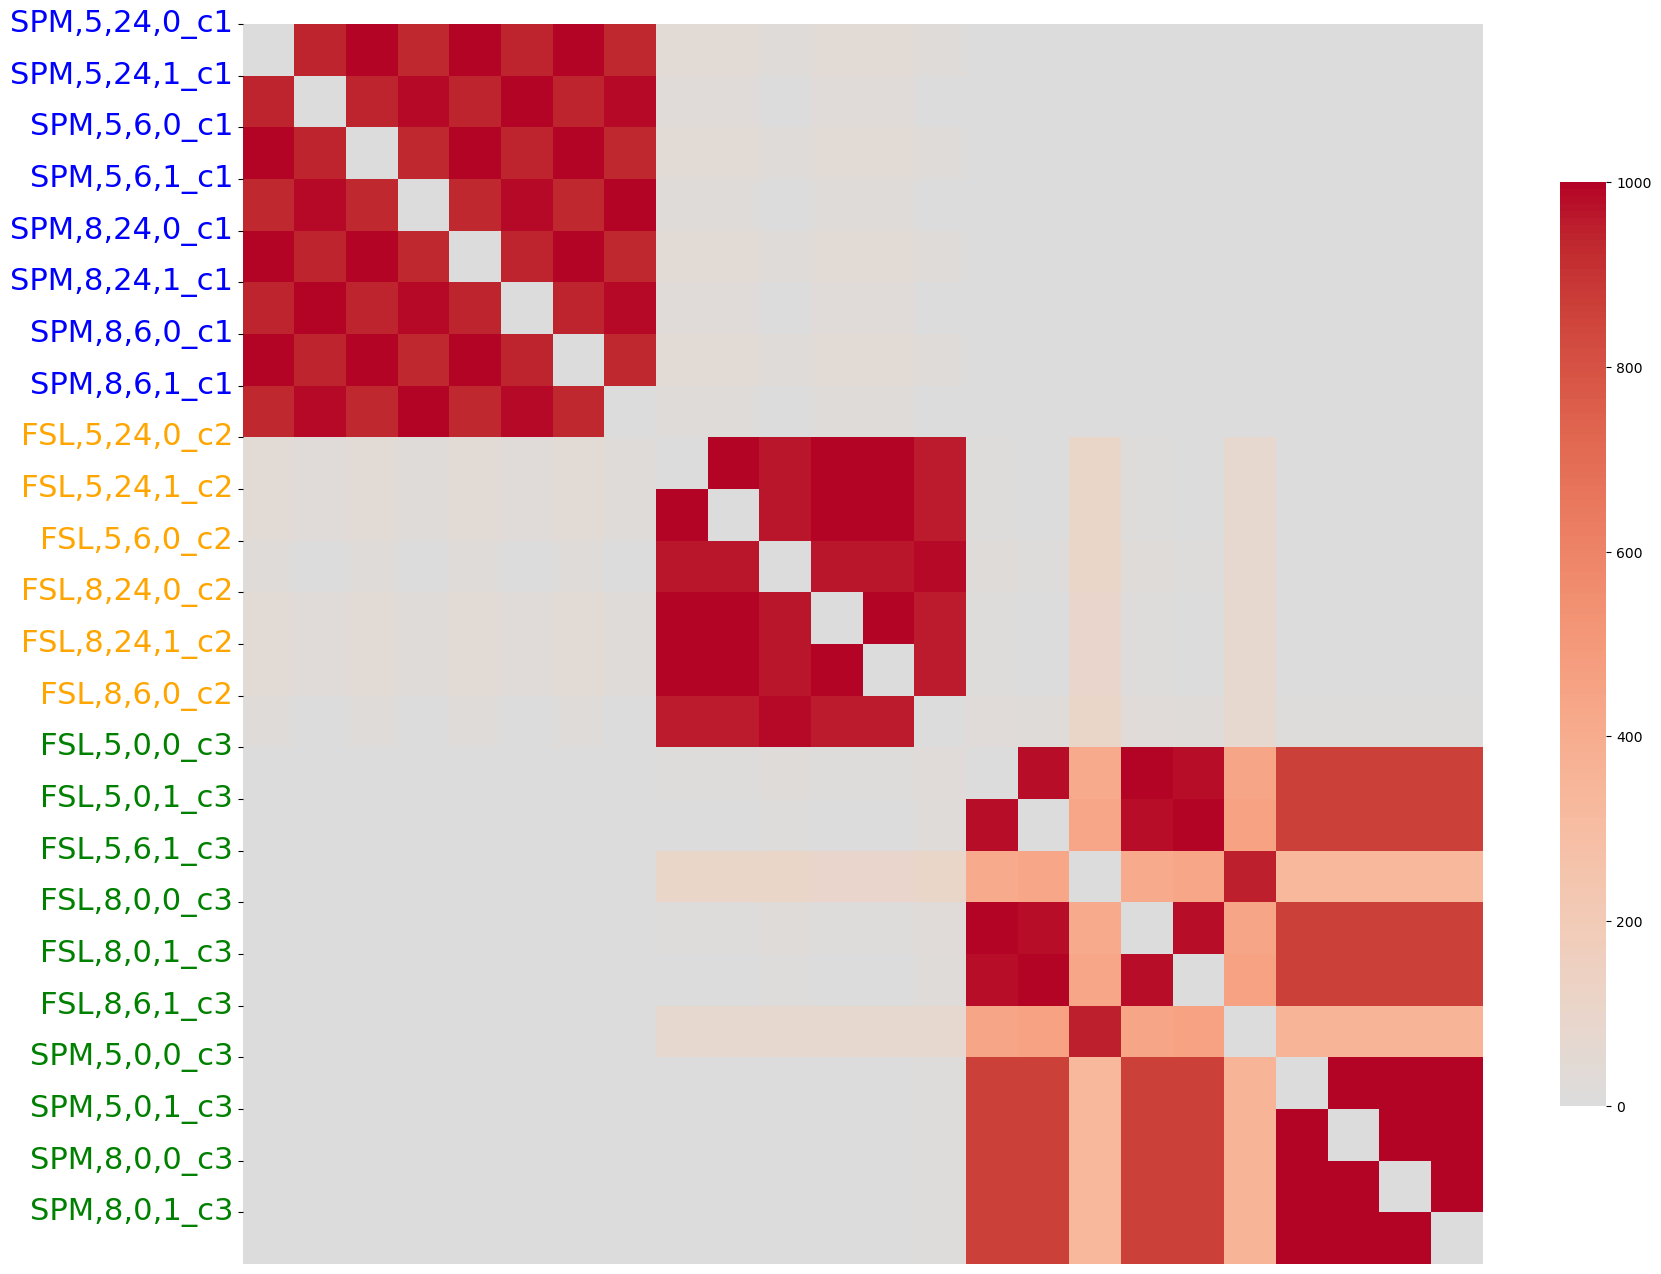

In [1]:
import louvain_matrix
louvain_matrix.main()

Computing mask...
Computing mean image...
Pipelines belonging to 0 : ['FSL,5,0,0', 'FSL,5,24,0', 'FSL,5,24,1', 'FSL,5,6,0', 'FSL,8,0,0', 'FSL,8,24,0', 'FSL,8,24,1', 'FSL,8,6,0']
Pipelines belonging to 1 : ['FSL,5,0,1', 'FSL,5,6,1', 'FSL,8,0,1', 'FSL,8,6,1']
Pipelines belonging to 2 : ['SPM,5,0,0', 'SPM,5,24,0', 'SPM,5,6,0', 'SPM,8,0,0', 'SPM,8,24,0', 'SPM,8,6,0']
Pipelines belonging to 3 : ['SPM,5,0,1', 'SPM,5,24,1', 'SPM,5,6,1', 'SPM,8,0,1', 'SPM,8,24,1', 'SPM,8,6,1']


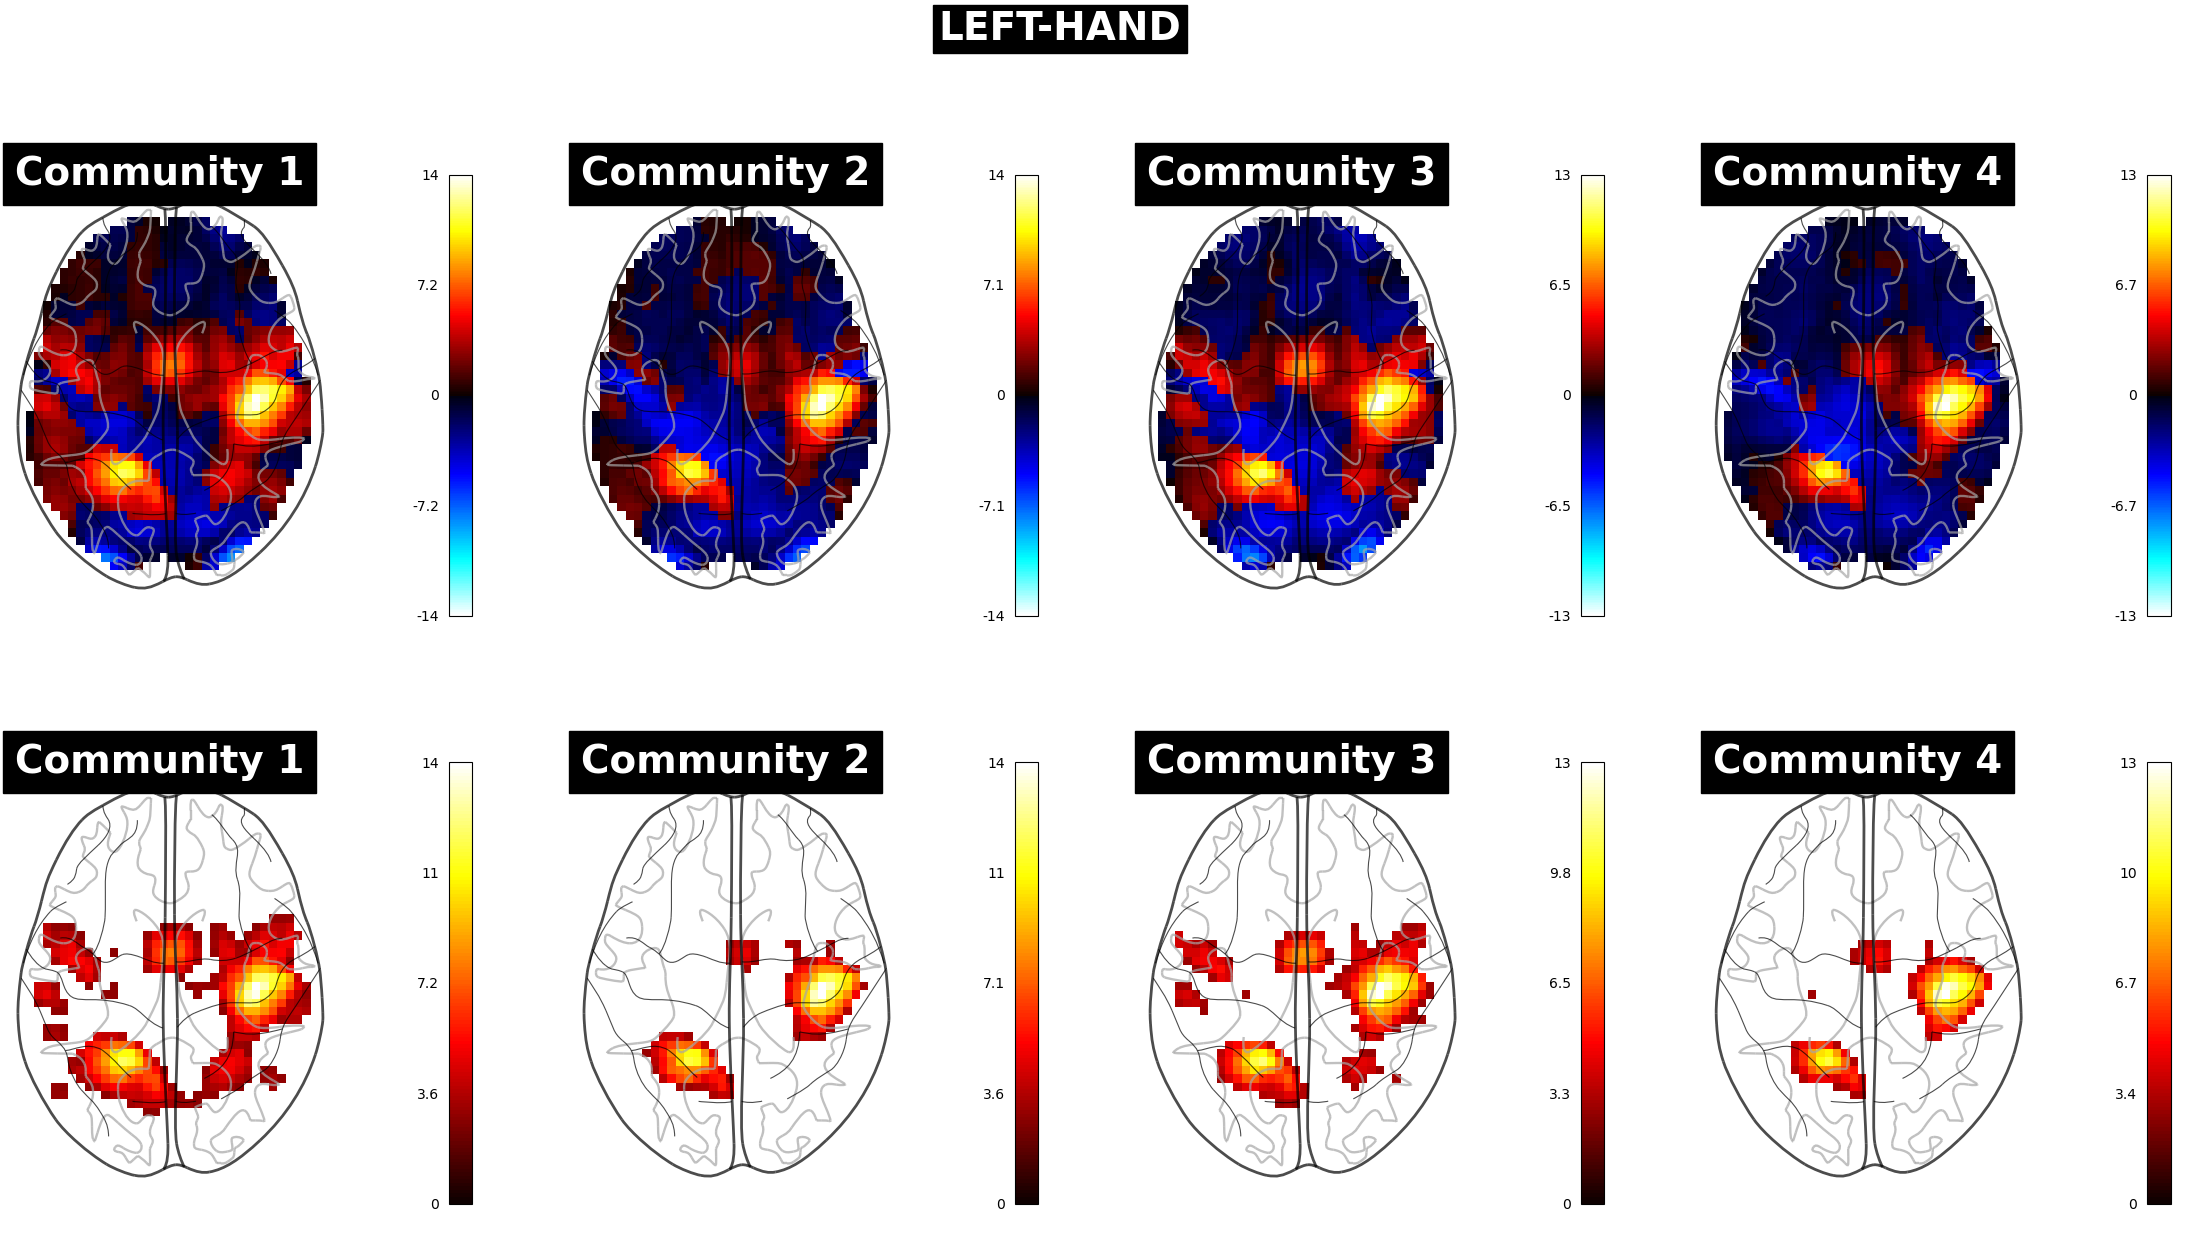

In [2]:
import mean_maps
mean_maps.main()